In [1]:
import glob
import h5py
import librosa
import numpy as np
import os
import scipy
import sklearn
import sys
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sys.path.append("..")
import localmodule

In [2]:
data_dir = localmodule.get_data_dir()
participant_paths = glob.glob("imitations_participant*.mat")
participant_paths.sort()
n_participants = len(participant_paths)
n_imitations = 100
imitation_matrix = []
species_matrix = []

for participant_path in tqdm.tqdm(participant_paths):
    imitation_list = []
    species_list = []
    
    with h5py.File(participant_path) as h5_file:
        for i in range(n_imitations):
            imitation_waveform = h5_file['#refs#'][
                h5_file["imitations"]["imitationAudio"][i][0]][0]
            species = int(h5_file['#refs#'][
                h5_file["imitations"]["species"][i][0]][0][0])
            imitation_list.append(imitation_waveform)
            species_list.append(species)
        imitation_matrix.append(imitation_list)
        species_matrix.append(species_list)
imitation_matrix = np.array(imitation_matrix)
species_matrix = np.array(species_matrix)

100%|██████████| 17/17 [00:13<00:00,  1.32it/s]


In [3]:
participant_id = 0
imitation_id = 0
hop_length = 512
half_event_length = 4096
sr = 44100
n_events = 2
n_mfcc = 12

mfcc_tensor = np.zeros((n_mfcc, n_events, n_participants, n_imitations))

for participant_id in tqdm.tqdm(range(n_participants)):
    for imitation_id in range(n_imitations):
        imitation_waveform = imitation_matrix[participant_id, imitation_id]

        rms = np.ravel(librosa.feature.rmse(
            imitation_waveform, frame_length=2*hop_length, hop_length=hop_length))
        sorting_indices = rms.argsort(axis=0)[::-1]

        for event_id in range(n_events):
            event_start = max(0, sorting_indices[event_id] * hop_length - half_event_length)
            event_stop = min(len(imitation_waveform),
                             sorting_indices[event_id] * hop_length + half_event_length)
            event_length = event_stop - event_start
            event_waveform = imitation_waveform[event_start:event_stop] * scipy.signal.hann(event_length)
            mfcc = librosa.feature.mfcc(y=event_waveform, n_mels=40, n_mfcc=(1+n_mfcc), sr=sr)[1:, :]
            mfcc_tensor[:, event_id, participant_id, imitation_id] = np.mean(mfcc, axis=1)
            
species_tensor = np.tile(species_matrix, (n_events, 1, 1))
mfcc_X = np.reshape(mfcc_tensor, (n_mfcc, n_events*n_participants*n_imitations)).T
mfcc_y = np.ravel(species_tensor) - 1

100%|██████████| 17/17 [00:09<00:00,  1.81it/s]


In [4]:
# Principal component analysis

pca_model = sklearn.decomposition.PCA().fit(mfcc_X)
pca_X = pca_model.transform(mfcc_X)

print('Variance explained in first 2 components:',
     pca_model.explained_variance_ratio_[0:2])

Variance explained in first 2 components: [0.30438207 0.23622944]


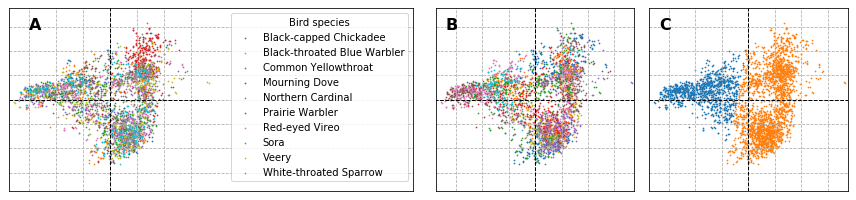

In [5]:
# Visualization of species

species_names_with_sci_names = \
    ['Black-capped chickadee ($Poecile atricapillus$)',
     'Black-throated blue warbler ($Setophaga caerulescens$)',
     'Common yellowthroat ($Geothlypis trichas$)',
     'Mourning dove ($Zenaida macroura$)',
     'Northern cardinal ($Cardinalis cardinalis$)',
     'Prairie warbler ($Setophaga discolor$)',
     'Red-eyed vireo ($Vireo olivaceus$)',
     'Sora ($Porzana carolina$)',
     'Veery ($Catharus fuscescens$)',
     'White-throated sparrow ($Zonotrichia albicollis$)']
marker_size = 2
plt.figure(figsize=(12,3))
metadata_path = 'BirdVox-imitation_metadata.mat'

xmax = 10*(np.max(10+np.abs(pca_X))//10)
n_species = len(np.unique(species_tensor))

with h5py.File(metadata_path) as h5_file:
    species_strings = [
        " ".join([x.capitalize() for x in
        "".join(list(map(chr, h5_file["#refs#"][h5_file["meta"]["species"]["speciesName"][i][0]][:]))).split("_")])
         for i in range(n_species)
    ]

ax1 = plt.subplot(1,2,1)
ax1.text(0.05, .95, 'A', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top')
plt.plot([0, 0], [-75, 75], '--', color='k', linewidth=1.0)
plt.plot([-75, 75], [0, 0], '--', color='k', linewidth=1.0)
for species_id in range(n_species): # 3 is kind of in one quadrent
    plt.scatter(
        pca_X[mfcc_y==species_id, 0], pca_X[mfcc_y==species_id, 1],
        marker='.', alpha=1.0, cmap='Set1', 
        label=species_strings[species_id],
        #label=species_names_with_sci_names[species_id],
        s=marker_size)
plt.gca().set_xticks(range(-60, 80, 20))
plt.gca().set_yticks(range(-60, 80, 20))
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().tick_params(length=0)
plt.xlim(-75, 225)
plt.ylim(-75, 75)
plt.legend(title="Bird species")
plt.grid(linestyle='--')

################################################################################
# Visualization of participants
participant_tensor = np.tile(np.arange(0, n_events*n_participants), (n_imitations, 1)).T
participant_y = np.ravel(participant_tensor)
participant_subset = [3, 5, 6] #np.arange(17)#[7, 10, 11, 12] [3, 5, 6]
participant_complementary_subset = [
    x for x in range(n_participants)
    if x not in participant_subset]

ax2 = plt.subplot(1,4,3)
ax2.text(0.05, .95, 'B', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top')
plt.plot([0, 0], [-xmax, xmax], '--', color='k', linewidth=1.0)
plt.plot([-xmax, xmax], [0, 0], '--', color='k', linewidth=1.0)
#for participant_id in participant_complementary_subset:
#    plt.scatter(
#        pca_X[participant_y==participant_id, 0], pca_X[participant_y==participant_id, 1],
#        marker='.', alpha=0.5, color='gray', s=marker_size)
for participant_id in np.arange(n_participants):#participant_subset:
    inds1 = participant_y==participant_id
    inds2 = participant_y==participant_id + n_participants
    inds = inds1 + inds2
    plt.scatter(
        pca_X[inds, 0], pca_X[inds, 1],
        marker='.', alpha=1.0, cmap='gray', label=participant_id, s=marker_size)
plt.gca().set_xticks(range(-300, 300, 20))
plt.gca().set_yticks(range(-300, 300, 20))
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().tick_params(length=0)
plt.xlim(-75, 75)
plt.ylim(-75, 75)
#plt.legend(title="Example participants")
plt.grid(linestyle='--')

################################################################################
# Visualization of k-means clusters
n_clusters = 2
kmeans_model = sklearn.cluster.KMeans(n_clusters=n_clusters).fit(mfcc_X)
kmeans_y = kmeans_model.labels_

labels = ['Mostly hummed', 'Mostly whistled']

ax3 = plt.subplot(1,4,4)
ax3.text(0.05, .95, 'C', transform=ax3.transAxes, fontsize=16, fontweight='bold', va='top')
plt.plot([0, 0], [-75, 75], '--', color='k', linewidth=1.0)
plt.plot([-75, 75], [0, 0], '--', color='k', linewidth=1.0)
for cluster_id in range(n_clusters):
    plt.scatter(
        pca_X[kmeans_y==cluster_id, 0], pca_X[kmeans_y==cluster_id, 1],
        marker='.', alpha=1.0,  s=marker_size)
plt.gca().set_xticks(range(-60, 80, 20))
plt.gca().set_yticks(range(-60, 80, 20))
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().tick_params(length=0)
plt.xlim(-75, 75)
plt.ylim(-75, 75)
#plt.legend(title='Clusters')
plt.grid(linestyle='--')


################################################################################
plt.tight_layout()
#plt.savefig("vihar2019_pca.png", dpi=1000, bbox_inches="tight")
#plt.savefig("vihar2019_pca.eps", bbox_inches="tight")

In [6]:
h5_file.close()